In [53]:
import torch
from torch.utils.data import DataLoader
from transformers import RobertaTokenizer, RobertaForSequenceClassification
import torch.optim as optim
import pandas as pd
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Load tokenizer and model
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=4)  # Adjust num_labels as needed

# Check if GPU is available and use it if possible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
             

In [18]:
# Load data
train_data = pd.read_csv('train_scaled.csv', delimiter=',')
valid_data = pd.read_csv('valid_scaled.csv', delimiter=',')
test_data = pd.read_csv('test_scaled.csv', delimiter=',', nrows=500)

# Combine code and code_comment columns into a single input
train_data['combined_input'] = train_data['code'] + ' ' + train_data['code_comment']
valid_data['combined_input'] = valid_data['code'] + ' ' + valid_data['code_comment']
test_data['combined_input'] = test_data['code'] + ' ' + test_data['code_comment']

# Ensure combined_input is treated as a string and fill NaN values
train_data['combined_input'] = train_data['combined_input'].fillna('').astype(str)
valid_data['combined_input'] = valid_data['combined_input'].fillna('').astype(str)
test_data['combined_input'] = test_data['combined_input'].fillna('').astype(str)

In [19]:
# Undersample the training data to balance the labels
min_count = train_data['label'].value_counts().min()  # Find the minimum count among all labels
balanced_train_data = train_data.groupby('label').apply(lambda x: x.sample(n=min_count, random_state=42)).reset_index(drop=True)

# Check the label distribution in the balanced training data
print("Balanced Training Data Label Distribution:")
print(balanced_train_data['label'].value_counts())

# Tokenize data
def tokenize_function(data):
    return tokenizer(data['combined_input'].tolist(), padding='max_length', truncation=True, max_length=512, return_tensors="pt")

train_encodings = tokenize_function(balanced_train_data)
valid_encodings = tokenize_function(valid_data)
test_encodings = tokenize_function(test_data)

# Convert to PyTorch Dataset
class BugDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = BugDataset(train_encodings, balanced_train_data['label'].values)
valid_dataset = BugDataset(valid_encodings, valid_data['label'].values)
test_dataset = BugDataset(test_encodings, test_data['label'].values)

# Create DataLoader
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=8, shuffle=False)

# Set up optimizer and loss function
optimizer = optim.AdamW(model.parameters(), lr=2e-5)
criterion = torch.nn.CrossEntropyLoss()  # No class weights needed as labels are balanced

# Training loop
model.train()
for epoch in range(5):  # Number of epochs
    total_loss = 0
    for batch in train_loader:
        optimizer.zero_grad()

        # Move batch to the device
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        # Forward pass
        outputs = model(input_ids, attention_mask=attention_mask)
        loss = criterion(outputs.logits, labels)
        total_loss += loss.item()

        # Backward pass
        loss.backward()
        optimizer.step()

    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch + 1}, Loss: {avg_loss}")

# Evaluation loop
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for batch in valid_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        predictions = torch.argmax(outputs.logits, dim=-1)
        correct += (predictions == labels).sum().item()
        total += labels.size(0)

accuracy = correct / total
print(f"Validation Accuracy: {accuracy}")

Balanced Training Data Label Distribution:
label
0    199
1    199
2    199
3    199
Name: count, dtype: int64
Epoch 1, Loss: 1.1907219636440276
Epoch 2, Loss: 1.0830272626876831
Epoch 3, Loss: 0.975777524113655
Epoch 4, Loss: 0.8863255751132965
Epoch 5, Loss: 0.8506821562349797
Validation Accuracy: 0.3380281690140845


In [20]:
print("Data type of labels in train_data:",train_data['label'].dtype)
print("Unique values in train_data['label']:",train_data['label'].unique())
print("Data type of labels in valid_data:", valid_data['label'].dtype)
print("Unique values in valid_data['label']:", valid_data['label'].unique())
print("Data type of labels in test_data:", test_data['label'].dtype)
print("Unique values in test_data['label']:", test_data['label'].unique())

Data type of labels in train_data: int64
Unique values in train_data['label']: [1 3 0 2]
Data type of labels in valid_data: int64
Unique values in valid_data['label']: [1 0 2 3]
Data type of labels in test_data: int64
Unique values in test_data['label']: [1 0 2 3]


In [21]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

# Evaluate the model on the test set
model.eval()
all_labels = []
all_predictions = []

with torch.no_grad():
    for batch in DataLoader(test_dataset, batch_size=8, shuffle=False):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        predictions = torch.argmax(outputs.logits, dim=-1)

        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predictions.cpu().numpy())

# Calculate metrics
accuracy = accuracy_score(all_labels, all_predictions)
precision = precision_score(all_labels, all_predictions, average='weighted')
recall = recall_score(all_labels, all_predictions, average='weighted')
f1 = f1_score(all_labels, all_predictions, average='weighted')

print("Test Set Evaluation Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Print a few examples of predicted and actual labels
print("Sample Predictions:")
for i in range(5):  # Display the first 5 predictions
    print(f"Predicted: {all_predictions[i]}, Actual: {all_labels[i]}")

Test Set Evaluation Metrics:
Accuracy: 0.3180
Precision: 0.6209
Recall: 0.3180
F1 Score: 0.3636
Sample Predictions:
Predicted: 0, Actual: 1
Predicted: 1, Actual: 0
Predicted: 0, Actual: 2
Predicted: 0, Actual: 1
Predicted: 3, Actual: 1


In [6]:
import seaborn as sns

# Check the distribution of classes
# sns.countplot(x='label', data=valid_data)
# plt.title('Class Distribution in validing Data')
# plt.show()

# Print the number of values in each category
category_counts = train_data['label'].value_counts()
print("Number of values in each category:")
print(category_counts)
category_counts = valid_data['label'].value_counts()
print("Number of values in each category:")
print(category_counts)
category_counts = test_data['label'].value_counts()
print("Number of values in each category:")
print(category_counts)


Number of values in each category:
label
1    429
3    140
2     67
0     64
Name: count, dtype: int64
Number of values in each category:
label
1    265
3     89
2     37
0     35
Name: count, dtype: int64
Number of values in each category:
label
1    313
3    104
2     44
0     41
Name: count, dtype: int64


In [22]:
# Generate a classification report
report = classification_report(all_labels, all_predictions)
print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

           0       0.12      0.83      0.20        41
           1       0.79      0.27      0.41       312
           2       0.51      0.44      0.48        43
           3       0.34      0.20      0.25       104

    accuracy                           0.32       500
   macro avg       0.44      0.44      0.33       500
weighted avg       0.62      0.32      0.36       500



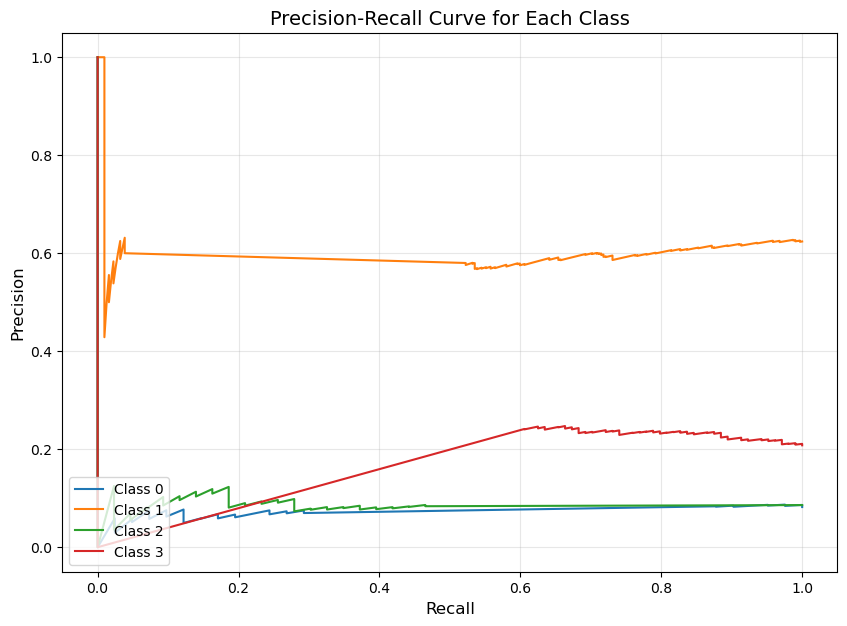

In [54]:
from sklearn.metrics import precision_recall_curve
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import torch
import numpy as np

# Assuming you have your model, DataLoader, and dataset already set up as in the previous code.

model.eval()  # Ensure the model is in evaluation mode
all_labels = []
all_predictions = []
all_probs = []  # To store predicted probabilities

with torch.no_grad():
    for batch in DataLoader(test_dataset, batch_size=8, shuffle=False):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        # Get model outputs
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        probs = torch.softmax(logits, dim=-1)  # Get probabilities
        predictions = torch.argmax(logits, dim=-1)

        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predictions.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())  # Store probabilities for the PR curve

# Binarize the labels and predictions for PR curve computation
y_test_binarized = label_binarize(all_labels, classes=[0, 1, 2, 3])
all_probs = np.array(all_probs)

# Plot Precision-Recall curve for each class
plt.figure(figsize=(10, 7))

for i in range(4):  # Loop through each class
    precision, recall, _ = precision_recall_curve(y_test_binarized[:, i], all_probs[:, i])
    plt.plot(recall, precision, label=f'Class {i}')

plt.xlabel('Recall', fontsize=12)
plt.ylabel('Precision', fontsize=12)
plt.title('Precision-Recall Curve for Each Class', fontsize=14)
plt.legend(loc="lower left", fontsize=10)
plt.grid(alpha=0.3)
plt.show()

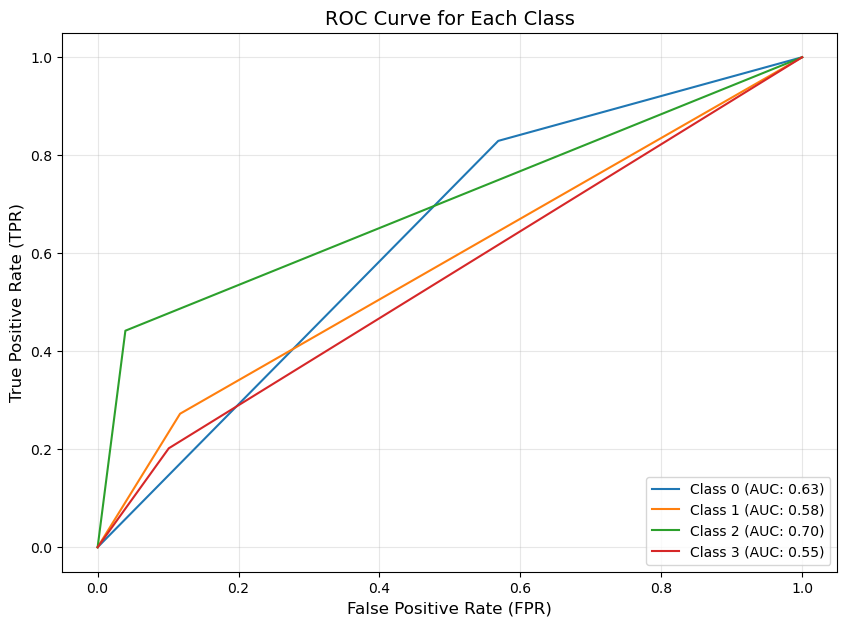

In [48]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np

# Binarize the labels for ROC curve computation
y_test_binarized = label_binarize(all_labels, classes=[0, 1, 2, 3])
all_predictions_binarized = label_binarize(all_predictions, classes=[0, 1, 2, 3])

# Compute ROC curve and AUC for each class
fpr = dict()  # False Positive Rate
tpr = dict()  # True Positive Rate
roc_auc = dict()  # AUC

for i in range(4):  # Loop through each class
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], all_predictions_binarized[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])  # Calculate AUC for each class

# Plot ROC curve
plt.figure(figsize=(10, 7))

for i in range(4):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC: {roc_auc[i]:.2f})')

plt.xlabel('False Positive Rate (FPR)', fontsize=12)
plt.ylabel('True Positive Rate (TPR)', fontsize=12)
plt.title('ROC Curve for Each Class', fontsize=14)
plt.legend(loc="lower right", fontsize=10)
plt.grid(alpha=0.3)
plt.show()


In [24]:
# Applying kappa statistics
from sklearn.metrics import cohen_kappa_score

kappa = cohen_kappa_score(all_labels, all_predictions)
print("Kappa Score:", kappa)


Kappa Score: 0.13269510545003216


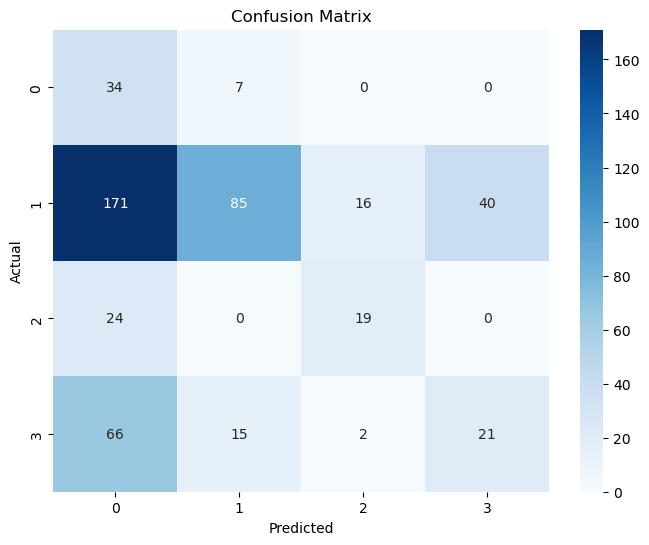

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
cm = confusion_matrix(all_labels, all_predictions)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [26]:
# Save the model
model.save_pretrained('./roberta_bug_severity_model')
tokenizer.save_pretrained('./roberta_bug_severity_model')

('./roberta_bug_severity_model/tokenizer_config.json',
 './roberta_bug_severity_model/special_tokens_map.json',
 './roberta_bug_severity_model/vocab.json',
 './roberta_bug_severity_model/merges.txt',
 './roberta_bug_severity_model/added_tokens.json')

In [27]:
from transformers import RobertaForSequenceClassification, RobertaTokenizer
import torch

# Load the model and tokenizer
model = RobertaForSequenceClassification.from_pretrained('./roberta_bug_severity_model')
tokenizer = RobertaTokenizer.from_pretrained('./roberta_bug_severity_model')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Bug severity labels (adjusted mapping: 0 - Critical, 3 - Low)
severity_labels = {
    0: "Critical",
    1: "High",
    2: "Medium",
    3: "Low"
}

# Function to predict bug severity
def predict_bug_severity(code, code_comment):
    model.eval()
    combined_input = code + ' ' + code_comment
    inputs = tokenizer(combined_input, return_tensors='pt', padding='max_length', truncation=True, max_length=512).to(device)
    
    with torch.no_grad():
        outputs = model(**inputs)
        prediction = torch.argmax(outputs.logits, dim=-1).item()
    
    return prediction, severity_labels[prediction]

# List of examples (one from each severity group)
examples = [
    {
        "code": """
        public void authenticate(String username, String password) {
            if (password.equals("123456")) {
                System.out.println("Authenticated");
            }
        }
        """,
        "comment": "Uses a hardcoded password, which is a critical security issue."
    },  # Critical (0)
    {
        "code": """
        public void processTransaction(double amount) {
            if (amount > 1000) {
                System.out.println("Transaction flagged for review.");
            }
        }
        """,
        "comment": "Flags transactions over $1000 but does not validate the input amount."
    },  # High (1)
    {
        "code": """
        public int calculateSum(int[] arr) {
            int sum = 0;
            for (int i : arr) {
                sum += i;
            }
            return sum;
        }
        """,
        "comment": "Does not handle null arrays, which may cause a NullPointerException."
    },  # Medium (2)
    {
        "code": "public void greetUser() { System.out.println(\"Welcome!\"); }",
        "comment": "Simple greeting method. No known issues."
    }  # Low (3)
]

# Make predictions for all examples
for idx, example in enumerate(examples):
    prediction, severity_label = predict_bug_severity(example["code"], example["comment"])
    print(f"Example {idx + 1}:")
    print(f"Code: {example['code'].strip()}")
    print(f"Comment: {example['comment']}")
    print(f"Predicted Bug Severity: {prediction} ({severity_label})\n")

Example 1:
Code: public void authenticate(String username, String password) {
            if (password.equals("123456")) {
                System.out.println("Authenticated");
            }
        }
Comment: Uses a hardcoded password, which is a critical security issue.
Predicted Bug Severity: 3 (Low)

Example 2:
Code: public void processTransaction(double amount) {
            if (amount > 1000) {
                System.out.println("Transaction flagged for review.");
            }
        }
Comment: Flags transactions over $1000 but does not validate the input amount.
Predicted Bug Severity: 1 (High)

Example 3:
Code: public int calculateSum(int[] arr) {
            int sum = 0;
            for (int i : arr) {
                sum += i;
            }
            return sum;
        }
Comment: Does not handle null arrays, which may cause a NullPointerException.
Predicted Bug Severity: 3 (Low)

Example 4:
Code: public void greetUser() { System.out.println("Welcome!"); }
Comment: Simple 

/Users/aswath/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


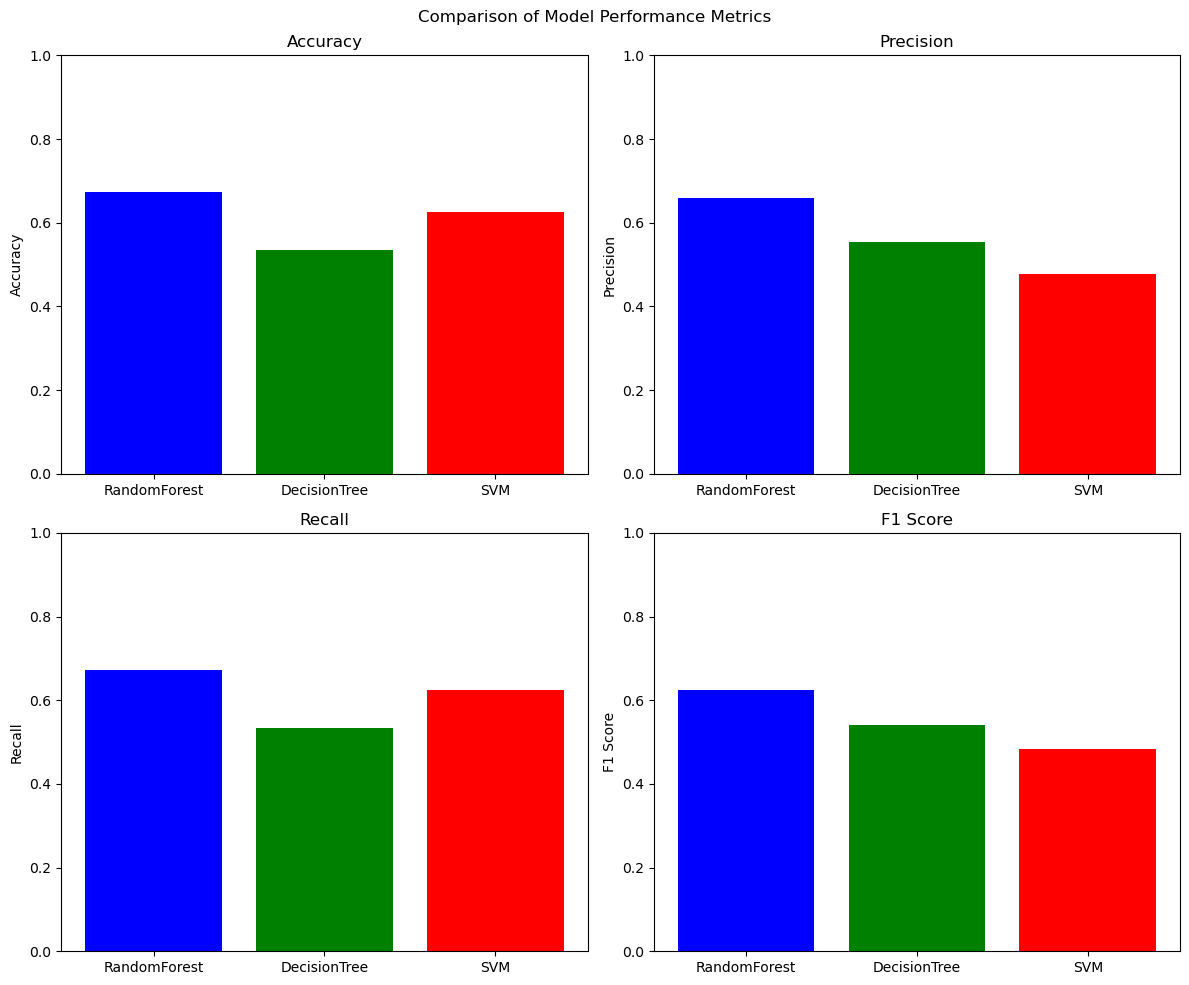

RandomForest Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.24      0.36        41
           1       0.68      0.93      0.79       313
           2       0.58      0.25      0.35        44
           3       0.62      0.25      0.36       104

    accuracy                           0.67       502
   macro avg       0.64      0.42      0.46       502
weighted avg       0.66      0.67      0.62       502

DecisionTree Classification Report:
              precision    recall  f1-score   support

           0       0.26      0.37      0.31        41
           1       0.69      0.64      0.67       313
           2       0.28      0.25      0.27        44
           3       0.36      0.40      0.38       104

    accuracy                           0.53       502
   macro avg       0.40      0.41      0.40       502
weighted avg       0.55      0.53      0.54       502

SVM Classification Report:
              precision    reca

/Users/aswath/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/aswath/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/aswath/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [28]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Load scaled data
train_data = pd.read_csv('train_scaled.csv')
valid_data = pd.read_csv('valid_scaled.csv')
test_data = pd.read_csv('test_scaled.csv')

# Extract features and labels
X_train = train_data.drop(columns=['label', 'code', 'code_comment'])
y_train = train_data['label']
X_valid = valid_data.drop(columns=['label', 'code', 'code_comment'])
y_valid = valid_data['label']
X_test = test_data.drop(columns=['label', 'code', 'code_comment'])
y_test = test_data['label']

# Drop non-numeric columns (like 'code' and 'code_comment')
X_train = X_train.select_dtypes(include=[np.number])
X_valid = X_valid.select_dtypes(include=[np.number])
X_test = X_test.select_dtypes(include=[np.number])

# Train RandomForest
rf_model = RandomForestClassifier()  # Removed class_weight
rf_model.fit(X_train, y_train)
rf_preds = rf_model.predict(X_test)

# Train DecisionTree
dt_model = DecisionTreeClassifier()  # Removed class_weight
dt_model.fit(X_train, y_train)
dt_preds = dt_model.predict(X_test)

# Train SVM
svm_model = SVC()  # Removed class_weight
svm_model.fit(X_train, y_train)
svm_preds = svm_model.predict(X_test)

# Calculate metrics for each model
models = ['RandomForest', 'DecisionTree', 'SVM']
predictions = [rf_preds, dt_preds, svm_preds]

metrics = {'Accuracy': [], 'Precision': [], 'Recall': [], 'F1 Score': []}

for preds in predictions:
    metrics['Accuracy'].append(accuracy_score(y_test, preds))
    metrics['Precision'].append(precision_score(y_test, preds, average='weighted'))
    metrics['Recall'].append(recall_score(y_test, preds, average='weighted'))
    metrics['F1 Score'].append(f1_score(y_test, preds, average='weighted'))

# Plot the metrics
fig, ax = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle('Comparison of Model Performance Metrics')

metric_names = list(metrics.keys())
for i, metric in enumerate(metric_names):
    ax[i // 2, i % 2].bar(models, metrics[metric], color=['blue', 'green', 'red'])
    ax[i // 2, i % 2].set_title(metric)
    ax[i // 2, i % 2].set_ylim(0, 1)
    ax[i // 2, i % 2].set_ylabel(metric)

plt.tight_layout()
plt.show()

# Print detailed classification reports for each model
print("RandomForest Classification Report:")
print(classification_report(y_test, rf_preds))

print("DecisionTree Classification Report:")
print(classification_report(y_test, dt_preds))

print("SVM Classification Report:")
print(classification_report(y_test, svm_preds))

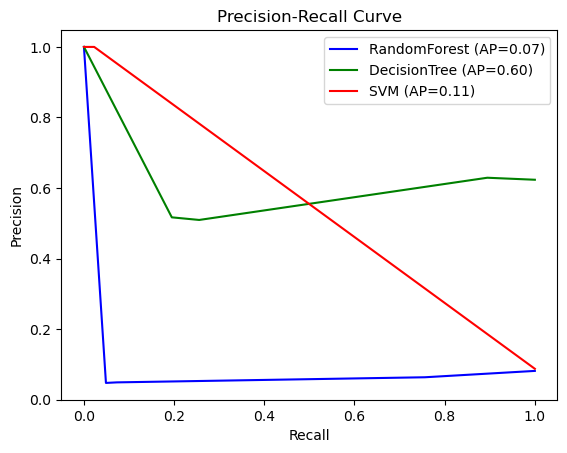

RandomForest Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.24      0.36        41
           1       0.68      0.93      0.79       313
           2       0.58      0.25      0.35        44
           3       0.62      0.25      0.36       104

    accuracy                           0.67       502
   macro avg       0.64      0.42      0.46       502
weighted avg       0.66      0.67      0.62       502

AUC-PR Score: 0.0669
DecisionTree Classification Report:
              precision    recall  f1-score   support

           0       0.26      0.37      0.31        41
           1       0.69      0.64      0.67       313
           2       0.28      0.25      0.27        44
           3       0.36      0.40      0.38       104

    accuracy                           0.53       502
   macro avg       0.40      0.41      0.40       502
weighted avg       0.55      0.53      0.54       502

AUC-PR Score: 0.5995
SVM Classificati

/Users/aswath/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/aswath/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/aswath/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [29]:
# Display AUC-PR curve and score for each model with above classification report
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.preprocessing import label_binarize
import itertools

y_test_binarized = label_binarize(y_test, classes=unique_classes)
colors = itertools.cycle(['b', 'g', 'r', 'c', 'm', 'y', 'k'])

plt.figure()
for i, model in enumerate(models):
    precision, recall, _ = precision_recall_curve(y_test_binarized[:, i], predictions[i])
    average_precision = average_precision_score(y_test_binarized[:, i], predictions[i])
    plt.plot(recall, precision, color=next(colors), label=f'{model} (AP={average_precision:.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

# Add AUC-PR score to the classification report
for i, model in enumerate(models):
    average_precision = average_precision_score(y_test_binarized[:, i], predictions[i])
    print(f"{model} Classification Report:")
    print(classification_report(y_test, predictions[i]))
    print(f"AUC-PR Score: {average_precision:.4f}")

In [31]:
pip install xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 5.7 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [33]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import precision_score, recall_score, f1_score
import pandas as pd
from tabulate import tabulate

# Train KNN
knn_model = KNeighborsClassifier()
knn_model.fit(X_train, y_train)
knn_preds = knn_model.predict(X_test)

# Train Naive Bayes
nb_model = GaussianNB()
nb_model.fit(X_train, y_train)
nb_preds = nb_model.predict(X_test)

# Train AdaBoost
ada_model = AdaBoostClassifier()
ada_model.fit(X_train, y_train)
ada_preds = ada_model.predict(X_test)

# Train XGBoost
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
xgb_model.fit(X_train, y_train)
xgb_preds = xgb_model.predict(X_test)

# Train MLP
mlp_model = MLPClassifier(max_iter=300)
mlp_model.fit(X_train, y_train)
mlp_preds = mlp_model.predict(X_test)

# Add predictions for new models
models = ['RandomForest', 'DecisionTree', 'SVM', 'KNN', 'Naive Bayes', 'Ada Boost', 'XGBoost', 'MLP']
predictions = [rf_preds, dt_preds, svm_preds, knn_preds, nb_preds, ada_preds, xgb_preds, mlp_preds]

# Recalculate metrics for all models
metrics = {'Model': models, 'Precision (Weighted)': [], 'Recall (Weighted)': [], 'F1 (Weighted)': [], 'F1 Per-class [0,1,2,3]': []}

for preds in predictions:
    metrics['Precision (Weighted)'].append(round(precision_score(y_test, preds, average='weighted'), 2))
    metrics['Recall (Weighted)'].append(round(recall_score(y_test, preds, average='weighted'), 2))
    metrics['F1 (Weighted)'].append(round(f1_score(y_test, preds, average='weighted'), 2))
    
    # Calculate F1 score for each class
    f1_per_class = f1_score(y_test, preds, average=None)
    metrics['F1 Per-class [0,1,2,3]'].append([round(f, 2) for f in f1_per_class.tolist()])

# Create a table from the metrics
results_df = pd.DataFrame(metrics)

# Display the table using tabulate
print(tabulate(results_df, headers='keys', tablefmt='pretty', showindex=False))


/Users/aswath/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:44:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


+--------------+----------------------+-------------------+---------------+--------------------------+
|    Model     | Precision (Weighted) | Recall (Weighted) | F1 (Weighted) |  F1 Per-class [0,1,2,3]  |
+--------------+----------------------+-------------------+---------------+--------------------------+
| RandomForest |         0.66         |       0.67        |     0.62      | [0.36, 0.79, 0.35, 0.36] |
| DecisionTree |         0.55         |       0.53        |     0.54      | [0.31, 0.67, 0.27, 0.38] |
|     SVM      |         0.48         |       0.63        |     0.48      |  [0.0, 0.77, 0.04, 0.0]  |
|     KNN      |         0.54         |        0.6        |     0.55      | [0.16, 0.74, 0.2, 0.26]  |
| Naive Bayes  |         0.41         |       0.55        |     0.47      | [0.0, 0.72, 0.11, 0.03]  |
|  Ada Boost   |         0.58         |       0.63        |     0.51      | [0.05, 0.77, 0.23, 0.02] |
|   XGBoost    |         0.6          |       0.63        |     0.59     

/Users/aswath/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/aswath/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/aswath/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


/Users/aswath/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:46:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/aswath/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/aswath/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


+--------------+----------------------+-------------------+---------------+--------------------------+
|    Model     | Precision (Weighted) | Recall (Weighted) | F1 (Weighted) |  F1 Per-class [0,1,2,3]  |
+--------------+----------------------+-------------------+---------------+--------------------------+
| RandomForest |         0.66         |       0.67        |     0.62      | [0.36, 0.79, 0.35, 0.36] |
| DecisionTree |         0.55         |       0.53        |     0.54      | [0.31, 0.67, 0.27, 0.38] |
|     SVM      |         0.48         |       0.63        |     0.48      |  [0.0, 0.77, 0.04, 0.0]  |
|     KNN      |         0.54         |        0.6        |     0.55      | [0.16, 0.74, 0.2, 0.26]  |
| Naive Bayes  |         0.41         |       0.55        |     0.47      | [0.0, 0.72, 0.11, 0.03]  |
|  Ada Boost   |         0.58         |       0.63        |     0.51      | [0.05, 0.77, 0.23, 0.02] |
|   XGBoost    |         0.6          |       0.63        |     0.59     

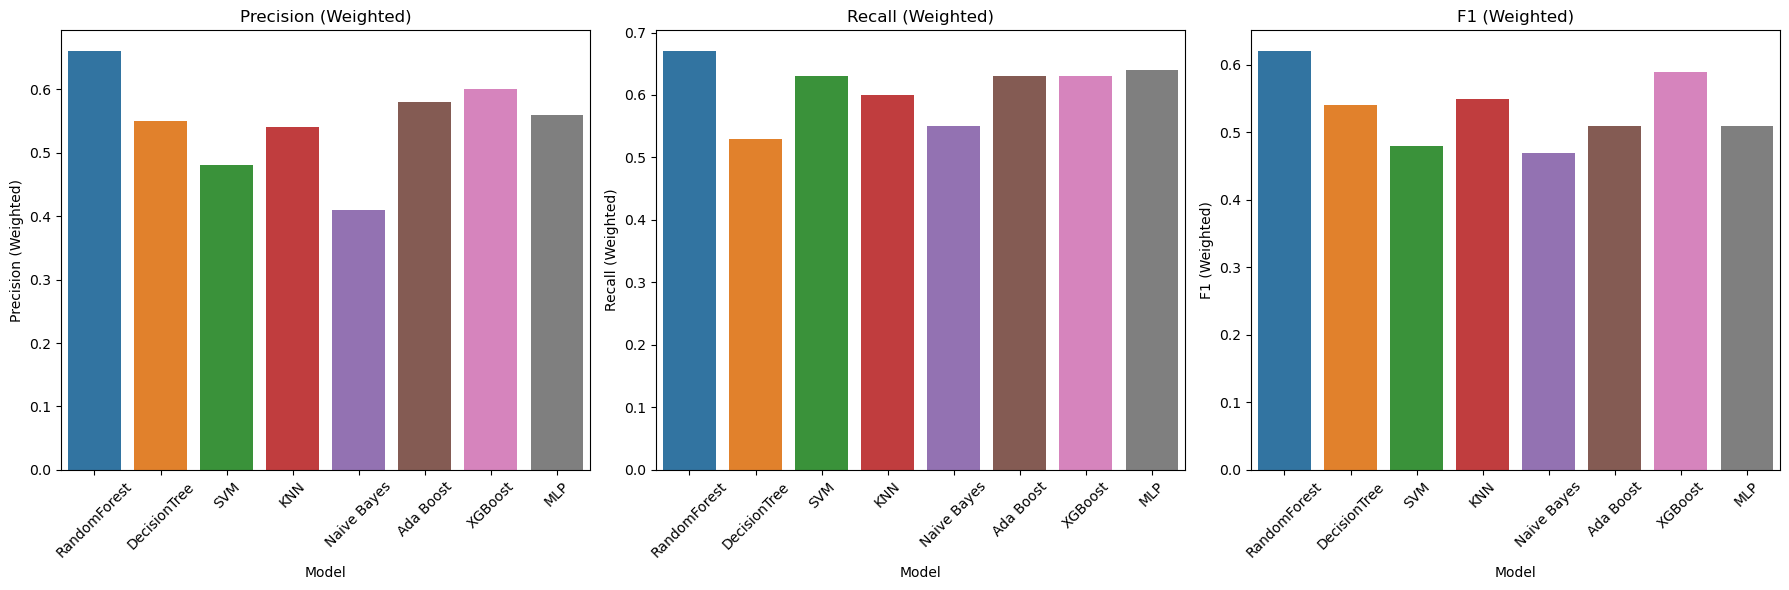

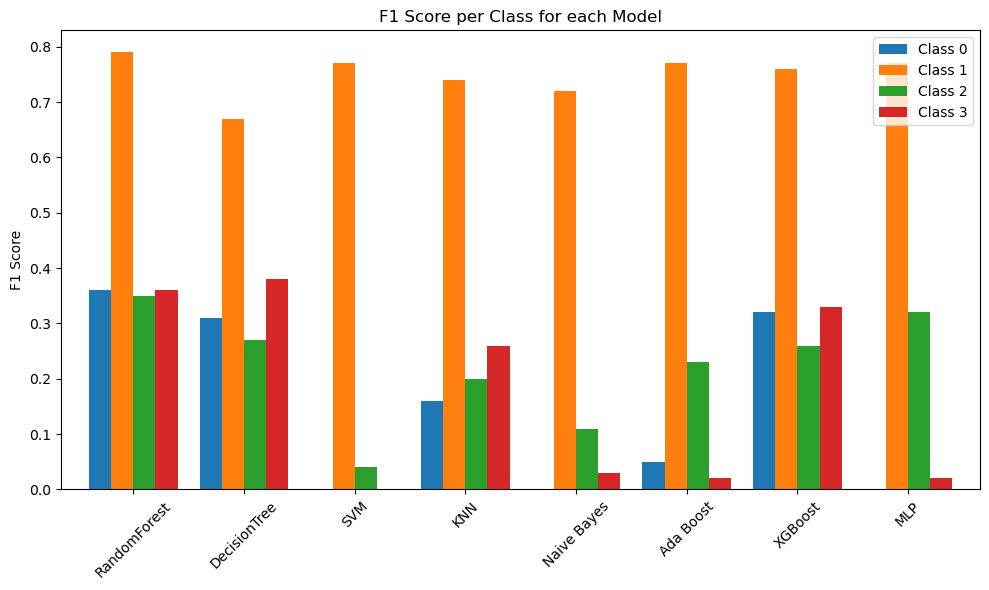

In [34]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import precision_score, recall_score, f1_score
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate

# Train KNN
knn_model = KNeighborsClassifier()
knn_model.fit(X_train, y_train)
knn_preds = knn_model.predict(X_test)

# Train Naive Bayes
nb_model = GaussianNB()
nb_model.fit(X_train, y_train)
nb_preds = nb_model.predict(X_test)

# Train AdaBoost
ada_model = AdaBoostClassifier()
ada_model.fit(X_train, y_train)
ada_preds = ada_model.predict(X_test)

# Train XGBoost
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
xgb_model.fit(X_train, y_train)
xgb_preds = xgb_model.predict(X_test)

# Train MLP
mlp_model = MLPClassifier(max_iter=300)
mlp_model.fit(X_train, y_train)
mlp_preds = mlp_model.predict(X_test)

# Add predictions for new models
models = ['RandomForest', 'DecisionTree', 'SVM', 'KNN', 'Naive Bayes', 'Ada Boost', 'XGBoost', 'MLP']
predictions = [rf_preds, dt_preds, svm_preds, knn_preds, nb_preds, ada_preds, xgb_preds, mlp_preds]

# Recalculate metrics for all models
metrics = {'Model': models, 'Precision (Weighted)': [], 'Recall (Weighted)': [], 'F1 (Weighted)': [], 'F1 Per-class [0,1,2,3]': []}

for preds in predictions:
    metrics['Precision (Weighted)'].append(round(precision_score(y_test, preds, average='weighted'), 2))
    metrics['Recall (Weighted)'].append(round(recall_score(y_test, preds, average='weighted'), 2))
    metrics['F1 (Weighted)'].append(round(f1_score(y_test, preds, average='weighted'), 2))
    
    # Calculate F1 score for each class
    f1_per_class = f1_score(y_test, preds, average=None)
    metrics['F1 Per-class [0,1,2,3]'].append([round(f, 2) for f in f1_per_class.tolist()])

# Create a DataFrame from the metrics
results_df = pd.DataFrame(metrics)

# Display the table using tabulate
print(tabulate(results_df, headers='keys', tablefmt='pretty', showindex=False))

# Visualization
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot Precision (Weighted)
sns.barplot(x='Model', y='Precision (Weighted)', data=results_df, ax=axes[0])
axes[0].set_title('Precision (Weighted)')
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45)

# Plot Recall (Weighted)
sns.barplot(x='Model', y='Recall (Weighted)', data=results_df, ax=axes[1])
axes[1].set_title('Recall (Weighted)')
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45)

# Plot F1 (Weighted)
sns.barplot(x='Model', y='F1 (Weighted)', data=results_df, ax=axes[2])
axes[2].set_title('F1 (Weighted)')
axes[2].set_xticklabels(axes[2].get_xticklabels(), rotation=45)

plt.tight_layout()
plt.show()

# Plot F1 per-class for each model
f1_per_class_df = pd.DataFrame(metrics['F1 Per-class [0,1,2,3]'], columns=['Class 0', 'Class 1', 'Class 2', 'Class 3'], index=models)

f1_per_class_df.plot(kind='bar', figsize=(10, 6), width=0.8)
plt.title('F1 Score per Class for each Model')
plt.xticks(rotation=45)
plt.ylabel('F1 Score')
plt.tight_layout()
plt.show()
